In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import time

import torch
import torch.nn as nn
import torchvision.transforms as tvtf
import torchvision.utils as tvutils

import gan_model_definitions

In [2]:
image_size = 256
image_content_types = ['Leaf', 'Flower', 'Entire', 'Fruit', 'Stem']

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        super(ImageDataset, self).__init__()
        self.image_paths = df.jpg.tolist()
        self.image_content = np.eye(len(image_content_types))[df.content.map(image_content_types.index)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = PIL.Image.open(self.image_paths[idx])        
        image_tensor = tvtf.Compose([
            tvtf.Resize(image_size),
            tvtf.CenterCrop(image_size),
            tvtf.ToTensor(),
            tvtf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])(image)
        
        image_content_tensor = torch.FloatTensor(self.image_content[idx])

        return image_tensor, image_content_tensor

In [3]:
device = torch.device("cuda:0")
batch_size = 64
dataset = ImageDataset(pd.read_json("data/data.json"))
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True, num_workers = 2)

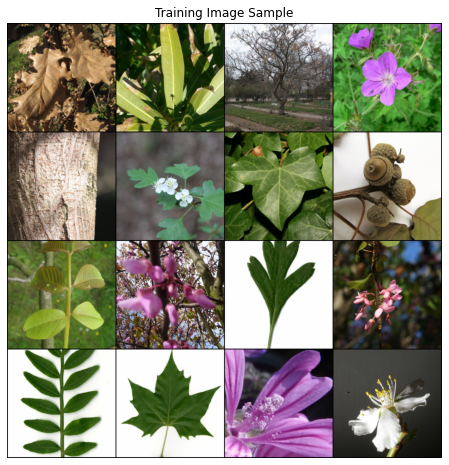

In [4]:
sample_batch = next(iter(dataloader))
plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("Training Image Sample")
plt.imshow(np.transpose(
    tvutils.make_grid(sample_batch[0][:16], padding = 2, normalize = True, nrow = 4),
    (1, 2, 0)
))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Create the generator
netG = gan_model_definitions.Generator(image_content_types).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

print(netG)

Generator(
  (image_conv): Sequential(
    (0): ParametrizedConvTranspose2d(
      200, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ParametrizedConvTranspose2d(
      2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ParametrizedConvTranspose2d(
      1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
     

In [7]:
netD = gan_model_definitions.Discriminator(image_content_types).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

print(netD)

Discriminator(
  (image_conv): Sequential(
    (0): ParametrizedConv2d(
      3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): ParametrizedConv2d(
      64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ParametrizedConv2d(
      128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): _SpectralNorm()
        )
      )
    )
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.

In [8]:
def create_noise():
    noise = torch.randn(batch_size, gan_model_definitions.nz - len(image_content_types), 1, 1, device = device)
    random_content_types = np.eye(len(image_content_types))[
        np.random.choice(range(len(image_content_types)), batch_size)
    ]
    return torch.cat((
        noise,
        torch.tensor(random_content_types).view((batch_size, len(image_content_types), 1, 1)).to(device)
    ), dim = 1).float()
    

In [9]:
# Learning rate for G optimizer
g_lr = 0.0004

# Learning rate for D optimizer
d_lr = 0.0008

# Beta1 hyperparam for Adam optimizers
beta1 = 0.7

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = create_noise()

# Establish convention for real and fake labels during training
# Use 0.9 instead of 1.0 (label smoothing)
real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr = g_lr, betas = (beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr = d_lr, betas = (beta1, 0.999))

In [14]:
num_epochs = 150

# Training Loop

# Lists to keep track of progress
img_list = []
class_list = []
G_losses = []
D_losses = []
iters = 0

start = time.time()
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (image, image_class) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_image = image.to(device)
        real_class = image_class.to(device)
        b_size = real_image.size(0)
        label = torch.full((b_size,), real_label, dtype = torch.float, device = device)
        # Forward pass real batch through D
        output = netD(real_image, real_class).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = create_noise()
        # Generate fake image batch with G
        fake_image, fake_class = netG(noise)
        label = torch.full((fake_image.size(0),), fake_label, dtype = torch.float, device = device)
        # Classify all fake batch with D
        output = netD(fake_image.detach(), fake_class.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake_image, fake_class).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            elapsed = time.time() - start
            elapsed_seconds = elapsed % 60
            elapsed_minutes = (elapsed // 60) % 60
            elapsed_hours = elapsed // 3600
            print('[%3d/%3d][%3d/%3d]  Loss_D: %.3f  Loss_G: %.3f  D(x): %.3f  D(G(z)): %.3f/%.3f  [Elapsed: %02d:%02d:%02d]'
                  % (epoch + 1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2,
                     elapsed_hours, elapsed_minutes, elapsed_seconds))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake_image, fake_class = netG(fixed_noise)
            img_list.extend(fake_image.detach().cpu())
            class_list.extend(fake_class.detach().cpu().argmax(1))

        iters += 1

[  1/150][  0/190]  Loss_D: 0.825  Loss_G: 4.513  D(x): 0.912  D(G(z)): 0.356/0.010  [Elapsed: 00:00:02]
[  1/150][ 50/190]  Loss_D: 1.127  Loss_G: 0.489  D(x): 0.396  D(G(z)): 0.037/0.686  [Elapsed: 00:01:33]
[  1/150][100/190]  Loss_D: 0.443  Loss_G: 5.351  D(x): 0.842  D(G(z)): 0.079/0.004  [Elapsed: 00:03:01]
[  1/150][150/190]  Loss_D: 0.540  Loss_G: 5.291  D(x): 0.650  D(G(z)): 0.002/0.005  [Elapsed: 00:04:30]
[  2/150][  0/190]  Loss_D: 0.348  Loss_G: 5.270  D(x): 0.932  D(G(z)): 0.005/0.005  [Elapsed: 00:05:41]
[  2/150][ 50/190]  Loss_D: 0.362  Loss_G: 5.850  D(x): 0.942  D(G(z)): 0.013/0.002  [Elapsed: 00:07:11]
[  2/150][100/190]  Loss_D: 0.771  Loss_G: 5.411  D(x): 0.939  D(G(z)): 0.308/0.004  [Elapsed: 00:08:40]
[  2/150][150/190]  Loss_D: 0.532  Loss_G: 3.395  D(x): 0.738  D(G(z)): 0.077/0.043  [Elapsed: 00:10:09]
[  3/150][  0/190]  Loss_D: 0.825  Loss_G: 2.198  D(x): 0.504  D(G(z)): 0.009/0.136  [Elapsed: 00:11:22]
[  3/150][ 50/190]  Loss_D: 0.377  Loss_G: 6.241  D(x):

[ 20/150][150/190]  Loss_D: 0.359  Loss_G: 5.311  D(x): 0.859  D(G(z)): 0.006/0.004  [Elapsed: 01:52:00]
[ 21/150][  0/190]  Loss_D: 0.362  Loss_G: 4.947  D(x): 0.929  D(G(z)): 0.019/0.006  [Elapsed: 01:53:12]
[ 21/150][ 50/190]  Loss_D: 0.355  Loss_G: 4.726  D(x): 0.890  D(G(z)): 0.014/0.012  [Elapsed: 01:54:41]
[ 21/150][100/190]  Loss_D: 0.343  Loss_G: 7.864  D(x): 0.921  D(G(z)): 0.001/0.000  [Elapsed: 01:56:10]
[ 21/150][150/190]  Loss_D: 0.448  Loss_G: 6.037  D(x): 0.854  D(G(z)): 0.089/0.002  [Elapsed: 01:57:38]
[ 22/150][  0/190]  Loss_D: 0.597  Loss_G: 3.958  D(x): 0.628  D(G(z)): 0.002/0.030  [Elapsed: 01:58:50]
[ 22/150][ 50/190]  Loss_D: 0.381  Loss_G: 5.236  D(x): 0.881  D(G(z)): 0.035/0.006  [Elapsed: 02:00:19]
[ 22/150][100/190]  Loss_D: 0.517  Loss_G: 5.091  D(x): 0.682  D(G(z)): 0.011/0.008  [Elapsed: 02:01:49]
[ 22/150][150/190]  Loss_D: 0.342  Loss_G: 8.185  D(x): 0.907  D(G(z)): 0.001/0.000  [Elapsed: 02:03:18]
[ 23/150][  0/190]  Loss_D: 0.631  Loss_G: 4.333  D(x):

[ 40/150][100/190]  Loss_D: 0.492  Loss_G: 5.689  D(x): 0.925  D(G(z)): 0.132/0.003  [Elapsed: 03:43:23]
[ 40/150][150/190]  Loss_D: 0.414  Loss_G: 4.280  D(x): 0.777  D(G(z)): 0.013/0.015  [Elapsed: 03:44:52]
[ 41/150][  0/190]  Loss_D: 0.359  Loss_G: 4.348  D(x): 0.851  D(G(z)): 0.008/0.012  [Elapsed: 03:46:04]
[ 41/150][ 50/190]  Loss_D: 0.405  Loss_G: 5.078  D(x): 0.926  D(G(z)): 0.055/0.007  [Elapsed: 03:47:33]
[ 41/150][100/190]  Loss_D: 0.765  Loss_G: 4.144  D(x): 0.549  D(G(z)): 0.002/0.036  [Elapsed: 03:49:02]
[ 41/150][150/190]  Loss_D: 0.467  Loss_G: 4.809  D(x): 0.921  D(G(z)): 0.112/0.010  [Elapsed: 03:50:31]
[ 42/150][  0/190]  Loss_D: 0.360  Loss_G: 5.316  D(x): 0.857  D(G(z)): 0.011/0.005  [Elapsed: 03:51:43]
[ 42/150][ 50/190]  Loss_D: 0.459  Loss_G: 4.173  D(x): 0.811  D(G(z)): 0.015/0.016  [Elapsed: 03:53:12]
[ 42/150][100/190]  Loss_D: 0.346  Loss_G: 5.484  D(x): 0.897  D(G(z)): 0.006/0.003  [Elapsed: 03:54:41]
[ 42/150][150/190]  Loss_D: 0.464  Loss_G: 4.250  D(x):

[ 60/150][ 50/190]  Loss_D: 0.368  Loss_G: 5.062  D(x): 0.923  D(G(z)): 0.030/0.006  [Elapsed: 05:34:36]
[ 60/150][100/190]  Loss_D: 1.288  Loss_G: 2.172  D(x): 0.944  D(G(z)): 0.559/0.187  [Elapsed: 05:36:04]
[ 60/150][150/190]  Loss_D: 0.368  Loss_G: 8.486  D(x): 0.836  D(G(z)): 0.000/0.000  [Elapsed: 05:37:33]
[ 61/150][  0/190]  Loss_D: 0.358  Loss_G: 5.465  D(x): 0.897  D(G(z)): 0.016/0.006  [Elapsed: 05:38:45]
[ 61/150][ 50/190]  Loss_D: 0.352  Loss_G: 5.407  D(x): 0.877  D(G(z)): 0.013/0.004  [Elapsed: 05:40:13]
[ 61/150][100/190]  Loss_D: 0.403  Loss_G: 4.755  D(x): 0.868  D(G(z)): 0.049/0.008  [Elapsed: 05:41:42]
[ 61/150][150/190]  Loss_D: 0.616  Loss_G: 5.645  D(x): 0.918  D(G(z)): 0.217/0.004  [Elapsed: 05:43:11]
[ 62/150][  0/190]  Loss_D: 0.394  Loss_G: 4.939  D(x): 0.832  D(G(z)): 0.032/0.007  [Elapsed: 05:44:23]
[ 62/150][ 50/190]  Loss_D: 0.363  Loss_G: 3.975  D(x): 0.922  D(G(z)): 0.021/0.020  [Elapsed: 05:45:51]
[ 62/150][100/190]  Loss_D: 1.238  Loss_G: 6.044  D(x):

[ 80/150][  0/190]  Loss_D: 0.760  Loss_G: 4.721  D(x): 0.907  D(G(z)): 0.315/0.011  [Elapsed: 07:25:52]
[ 80/150][ 50/190]  Loss_D: 0.408  Loss_G: 4.760  D(x): 0.882  D(G(z)): 0.058/0.009  [Elapsed: 07:27:21]
[ 80/150][100/190]  Loss_D: 0.363  Loss_G: 4.569  D(x): 0.915  D(G(z)): 0.022/0.010  [Elapsed: 07:28:50]
[ 80/150][150/190]  Loss_D: 0.358  Loss_G: 4.901  D(x): 0.871  D(G(z)): 0.012/0.008  [Elapsed: 07:30:19]
[ 81/150][  0/190]  Loss_D: 0.746  Loss_G: 3.513  D(x): 0.942  D(G(z)): 0.290/0.038  [Elapsed: 07:31:31]
[ 81/150][ 50/190]  Loss_D: 0.344  Loss_G: 5.913  D(x): 0.902  D(G(z)): 0.004/0.002  [Elapsed: 07:33:00]
[ 81/150][100/190]  Loss_D: 0.389  Loss_G: 4.839  D(x): 0.906  D(G(z)): 0.048/0.011  [Elapsed: 07:34:29]
[ 81/150][150/190]  Loss_D: 0.418  Loss_G: 4.175  D(x): 0.813  D(G(z)): 0.036/0.021  [Elapsed: 07:35:59]
[ 82/150][  0/190]  Loss_D: 0.343  Loss_G: 5.404  D(x): 0.903  D(G(z)): 0.006/0.004  [Elapsed: 07:37:11]
[ 82/150][ 50/190]  Loss_D: 0.620  Loss_G: 4.859  D(x):

[ 99/150][150/190]  Loss_D: 0.604  Loss_G: 5.070  D(x): 0.941  D(G(z)): 0.213/0.005  [Elapsed: 09:17:29]
[100/150][  0/190]  Loss_D: 1.667  Loss_G: 0.485  D(x): 0.937  D(G(z)): 0.711/0.679  [Elapsed: 09:18:40]
[100/150][ 50/190]  Loss_D: 0.482  Loss_G: 5.425  D(x): 0.701  D(G(z)): 0.009/0.007  [Elapsed: 09:20:09]
[100/150][100/190]  Loss_D: 0.581  Loss_G: 2.400  D(x): 0.672  D(G(z)): 0.047/0.106  [Elapsed: 09:21:38]
[100/150][150/190]  Loss_D: 0.352  Loss_G: 5.537  D(x): 0.930  D(G(z)): 0.006/0.003  [Elapsed: 09:23:07]
[101/150][  0/190]  Loss_D: 0.400  Loss_G: 2.210  D(x): 0.943  D(G(z)): 0.045/0.146  [Elapsed: 09:24:18]
[101/150][ 50/190]  Loss_D: 0.398  Loss_G: 4.297  D(x): 0.797  D(G(z)): 0.013/0.016  [Elapsed: 09:25:47]
[101/150][100/190]  Loss_D: 0.375  Loss_G: 4.887  D(x): 0.891  D(G(z)): 0.032/0.007  [Elapsed: 09:27:16]
[101/150][150/190]  Loss_D: 0.358  Loss_G: 4.905  D(x): 0.888  D(G(z)): 0.017/0.007  [Elapsed: 09:28:45]
[102/150][  0/190]  Loss_D: 0.362  Loss_G: 4.961  D(x):

[119/150][100/190]  Loss_D: 0.372  Loss_G: 7.066  D(x): 0.818  D(G(z)): 0.001/0.001  [Elapsed: 11:08:55]
[119/150][150/190]  Loss_D: 0.413  Loss_G: 7.375  D(x): 0.782  D(G(z)): 0.001/0.000  [Elapsed: 11:10:24]
[120/150][  0/190]  Loss_D: 0.350  Loss_G: 5.148  D(x): 0.923  D(G(z)): 0.012/0.005  [Elapsed: 11:11:36]
[120/150][ 50/190]  Loss_D: 0.380  Loss_G: 4.209  D(x): 0.920  D(G(z)): 0.042/0.017  [Elapsed: 11:13:05]
[120/150][100/190]  Loss_D: 0.344  Loss_G: 6.040  D(x): 0.895  D(G(z)): 0.006/0.003  [Elapsed: 11:14:34]
[120/150][150/190]  Loss_D: 0.351  Loss_G: 6.087  D(x): 0.898  D(G(z)): 0.014/0.003  [Elapsed: 11:16:03]
[121/150][  0/190]  Loss_D: 0.347  Loss_G: 5.234  D(x): 0.886  D(G(z)): 0.012/0.007  [Elapsed: 11:17:15]
[121/150][ 50/190]  Loss_D: 0.376  Loss_G: 3.974  D(x): 0.886  D(G(z)): 0.038/0.022  [Elapsed: 11:18:43]
[121/150][100/190]  Loss_D: 0.396  Loss_G: 5.214  D(x): 0.773  D(G(z)): 0.004/0.007  [Elapsed: 11:20:12]
[121/150][150/190]  Loss_D: 0.354  Loss_G: 5.226  D(x):

[139/150][ 50/190]  Loss_D: 0.338  Loss_G: 6.257  D(x): 0.872  D(G(z)): 0.002/0.001  [Elapsed: 13:00:23]
[139/150][100/190]  Loss_D: 0.348  Loss_G: 5.197  D(x): 0.923  D(G(z)): 0.010/0.006  [Elapsed: 13:01:52]
[139/150][150/190]  Loss_D: 0.359  Loss_G: 4.648  D(x): 0.929  D(G(z)): 0.018/0.018  [Elapsed: 13:03:21]
[140/150][  0/190]  Loss_D: 0.366  Loss_G: 2.422  D(x): 0.940  D(G(z)): 0.019/0.125  [Elapsed: 13:04:33]
[140/150][ 50/190]  Loss_D: 0.346  Loss_G: 5.338  D(x): 0.907  D(G(z)): 0.011/0.006  [Elapsed: 13:06:02]
[140/150][100/190]  Loss_D: 0.485  Loss_G: 3.613  D(x): 0.920  D(G(z)): 0.129/0.035  [Elapsed: 13:07:31]
[140/150][150/190]  Loss_D: 0.354  Loss_G: 4.467  D(x): 0.914  D(G(z)): 0.021/0.012  [Elapsed: 13:09:00]
[141/150][  0/190]  Loss_D: 0.361  Loss_G: 4.922  D(x): 0.859  D(G(z)): 0.016/0.008  [Elapsed: 13:10:12]
[141/150][ 50/190]  Loss_D: 0.344  Loss_G: 6.967  D(x): 0.926  D(G(z)): 0.003/0.001  [Elapsed: 13:11:41]
[141/150][100/190]  Loss_D: 0.729  Loss_G: 3.929  D(x):

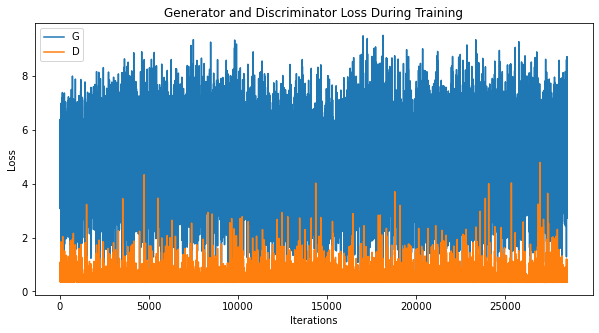

In [15]:
plt.figure(figsize = (10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label = "G")
plt.plot(D_losses, label = "D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

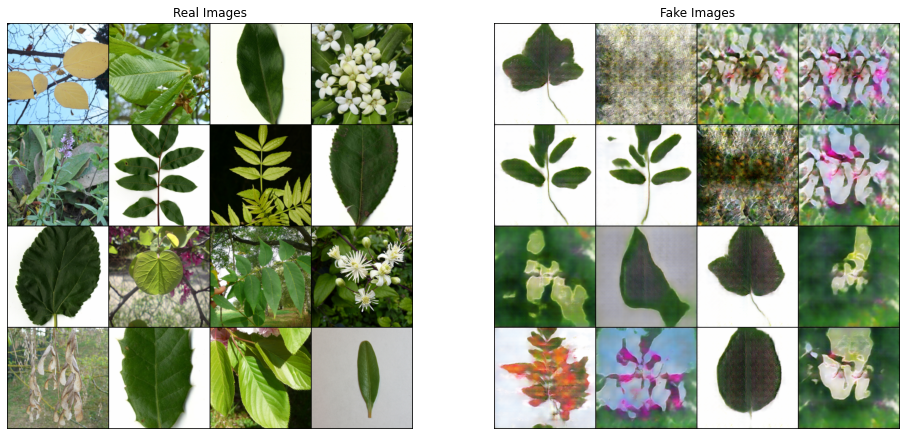

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize = (16, 16))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(
    tvutils.make_grid(real_batch[0][:16], normalize = True, nrow = 4),
    (1, 2, 0))
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(
    tvutils.make_grid(img_list[-16:], padding = 2, normalize = True, nrow = 4),
    (1, 2, 0)
))

plt.show()

In [17]:
torch.save(netG.state_dict(), "models/256x256.pkl")